This notebook was created at 11:29 09/10/20

Logistic regression applied to classification of simulated isotropic and liquid crystal (LC) textures

This notebook is meant as an initial proof-of-concept for the overall aim of classifying LC phases from textures. This proof-of-concept will be to test the binary classification of textures representing isotopic and non-isotropic (LC) phases. These textures will be simulated, generating the data. 

Isotropic is represented as an (almost) completely black image. This is the texture obtained for an isotropic phase using the method of polarizing microscopy. The LC phase will be represented by textures that aren't completely black.

Specifically this classification will be implemented using a simple logistic regression unit as this was done with a LeNet-5 inspired CNN architecture which seemed to be overkill.

We'll might use keras and/or tensorflow.

In [1]:
pip install tensorflow keras numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras.backend as K

Define the function for generating the simulated texture images. The images will be 32x32 previously used in the implementation of the LeNet-5 inspired CNN (a choice made so that the size matches the size that LeNet-5 was designed for).

In [4]:
def random_image_and_labels_generator(image_shape, N):
    """
    Generates random images and their corresponding labels
    (1 for bright/LC)

    Parameters
    ----------
    image_shape : tuple
        Shape of images we want to generate
    N : int
        number of images we want to generate

    Returns
    -------
    images : np.array
        Generated images together in an array of size (N, image height, image width, 1)
    labels : np.array
        The corresponding labels for the generated images of shape (N, 1)

    """
    # Add the images to an array
    images = np.zeros((1, image_shape[0], image_shape[1], 1)) # we'll need to remove this entry of zeros
    
    for i in range(N):
        # Generate image of size image_size with random
        # pixel values between 0 and 1 (representing a random
        # normalized image)
        image = np.random.rand(1, image_shape[0], image_shape[1], 1) # size (pixels, pixels)
        images = np.concatenate((images, image), axis = 0) # will be size (N, pixels, pixels)
    
    images = np.delete(images, 0, axis = 0)
    # Generate labels, 1
    labels = np.zeros((N, 1)) + 1
    
    return images, labels

In [5]:
def generate_data(image_shape, N_examples):
    """
    Generate the data for this classification problem

    Parameters
    ----------
    image_shape : tuple
        Shape of images we're dealing with
    N_examples : int
        Number of examples we're generating for the dataset

    Returns
    -------
    images_shuffled : np.array
        Shuffled images that were generated of size (N_examples, image height, image width, 1)
    labels_shuffled : np.array
        Labels corresponding to the shuffled images, 1 for LC and 0 for isotropic, of size (N_examples, 1)

    """
    N = int(N_examples/2) # Won't work properly for odd values of N_examples right now

    # Generate LC images and labels (1 for LC image)
    images_LC, labels_LC = random_image_and_labels_generator(image_shape, N)
    
    # Generate isotropic images and labels (0 for
    # isotropic image) by adding zeros to dataset
    images_iso, _ = random_image_and_labels_generator(image_shape, N)
    images_iso_noise = images_iso * 0.1 # this should simulate noisy isotropic images
    labels_iso = np.zeros((N, 1))
    
    images_ordered = np.concatenate((images_LC, images_iso_noise), axis = 0)
    labels_ordered = np.concatenate((labels_LC, labels_iso), axis = 0)

    # randomly shuffle the LC and iso images and labels
    images_shuffled, labels_shuffled = shuffle(images_ordered, labels_ordered)
    
    return images_shuffled, labels_shuffled

Generate some data.

In [6]:
image_shape = (32,32)
N_examples = 1000
images, labels = generate_data(image_shape, N_examples)

Let's look at some of the images and make sure the labels are matching up.

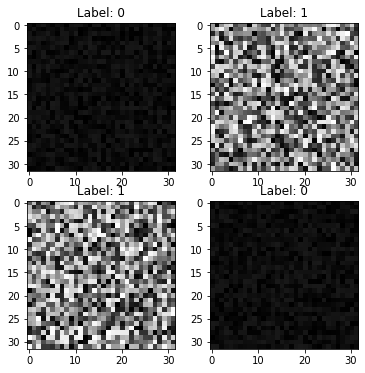

In [7]:
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%labels[i])
    plt.imshow(images[i,:,:].reshape([32,32]),cmap='gray', vmin=0, vmax=1);

Now we'll split the data into train and test sets.

In [8]:
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.33)

print ("Number of training examples = " + str(images_train.shape[0]))
print ("Number of test examples = " + str(images_test.shape[0]))
print ("X_train shape: " + str(images_train.shape))
print ("Y_train shape: " + str(labels_train.shape))
print ("X_test shape: " + str(images_test.shape))
print ("Y_test shape: " + str(labels_test.shape))

Number of training examples = 670
Number of test examples = 330
X_train shape: (670, 32, 32, 1)
Y_train shape: (670, 1)
X_test shape: (330, 32, 32, 1)
Y_test shape: (330, 1)


We need to flatten the images into feature vectors to be fed into the logistic regression unit.

In [9]:
def flatten(images):
    """
    Flattens the input greyscale image matrix 
    into a vector
    
    Parameters
    ----------
    images : np.array 
        image matrix of size (N,n_px,n_px,1)

    Returns
    -------
    flattened_image : np.array
        flattened image of size (n_px*n_px,N)

    """
    
    return images.reshape(images.shape[0], -1).T

In [10]:
images_train_flat = flatten(images_train)
images_test_flat = flatten(images_test)

print ("Number of training examples = " + str(images_train_flat.shape[1]))
print ("Number of test examples = " + str(images_test_flat.shape[1]))
print("X_train_flat shape: " + str(images_train_flat.shape))
print("X_test_flat shape: " + str(images_test_flat.shape))

Number of training examples = 670
Number of test examples = 330
X_train_flat shape: (1024, 670)
X_test_flat shape: (1024, 330)


Define a function to initial the weights and bias of the perceptron.

In [11]:
def initialize_parameters(n_w):
    """
    Initialize w parameter vector with small random values
     and bias with zeros

    Parameters
    ----------
    n_w : int
        number of w paramters to be initialized in w vector
        equal to to the number of input features
        (image height * image width)

    Returns
    -------
    w : np.array
        vector of weights initialized with small random values
        of size (n_w, 1)
    b : float
        zerp initialized bias

    """
    
    w = np.random.rand(n_w, 1) * np.sqrt(1/n_w)
    b = np.zeros((1,1))
    
    return w, b

In [16]:
def sigmoid(x):
    """
    Compute the sigmoid of x

    Parameters
    ----------
    x : np.array or float
        value/values to be put into sigmoid function

    Returns
    -------
    s : np.array or float
        sigmoid of x

    """
    s = 1 / (1 + np.exp(-x))
    
    return s

Define a function which will calculate the current prediction based on the current parameters (W and b) and then use gradient descent to improve the parameters.

In [12]:
def update_weights(w, b, x, d, alpha):
    """
    Update the values of weights and bias according to
    the value of difference between computed outputs
    and desired ouputs

    Parameters
    ----------
    w : np.array
        vector of weights of size (height*width, 1)
    b : float
        bias
    x : np.array
        training data of size (height*width, N)
    d : np.array
        desired outputs for training data of size
        (N, 1)
    N : int
        number of examples

    Returns
    -------
    w_new : np.array
        updated value of weights
    b_new : float
        updated value of bias
    pc_error : float
        total percentage error of current prediction
    pc_accuracy : float
        total percentage accuracy

    """
    N = x.shape[1]
    
    # Compute forward propagation/activation of single sigmoid unit
    y = np.reshape(sigmoid(np.dot(x.T, w) + b), (d.shape))
    y_pred = np.reshape(np.array([float(y[i] > 0.5) for i in range(y.shape[0])]), d.shape)
    diff = d - y
    
    # Calculate accuracy/error metrics
    pc_error = float(np.sum(y_pred != d)) / N * 100
    pc_accuracy = float(np.sum(y_pred == d)) / N * 100

    # Update weights
    dw = np.dot(x, diff)
    db = np.sum(diff)
    
    w_new = w + (alpha * dw)
    b_new = b + (alpha * db)
    
    
    return w_new, b_new, pc_error, pc_accuracy

Define the model which will iterate to continually improve the parameters.

In [13]:
def single_perceptron_model_train(images_train, labels_train, alpha = 0.001, num_iter = 20):
    """
    Train a single perceptron model

    Parameters
    ----------
    images_train : np.array
        falttened greyscale (0s and 1s) image matrix 
        of size (height*width, N)
    labels_train : np.array
        labels corresponding to the training images of size (N,1)
    alpha : float, optional
        learning rate The default is 0.001.
    num_iter : float, optional
        number of iteration of gradient descent we will perform. The default is 20.

    Returns
    -------
    w : np.array
        final trained values of weights
    b : float
        final trained value of bias
    pc_error : float
        percentage error achieved once training has been completed
    pc_accuracy : float
        percentage accuracy achieved once training has been completed
    """
    x = images_train
    N = x.shape[1] # numnber of training examples
    d = labels_train
    w, b = initialize_parameters(x.shape[0])
   
    # Gradient descent
    for i in range(1, num_iter+1):
        w, b, pc_error, pc_accuracy = update_weights(w, b, x, d, alpha)
        if i % 1 == 0:
            print("Interation " + str(i) + ": % Error on training data = " + str(pc_error))
            print("Interation " + str(i) + ": % accuracy on training data = " + str(pc_accuracy))
    
    print()
    print("% error on training data: " + str(pc_error))
    print("% accuracy on training data = " + str(pc_accuracy))
    
    return w, b, pc_error, pc_accuracy

Define a function that will generate a prediction on the test set using the trained parameters.

In [14]:
def single_perceptron_model_predict(images_test, labels_test, w, b):
    """
    Get prediction on test data

    Parameters
    ----------
    images_test : np.array
        flattened greyscale (0s and 1s) image matrix 
        of size (height*width, N)
    labels_test : np.array
        labels corresponding to the test images of size (N,1)
    w : np.array
        final trained values of weights
    b : float
        final trained value of bias

    Returns
    -------
    y_pred : TYPE
        final test predictions
    pc_error : float
        percentage error achieved on test data
    pc_accuracy : float
        percentage accuracy achieved on test data
        

    """
    x = images_test
    N = x.shape[1] # numnber of test examples
    d = labels_test
    
    # Compute prediction
    y = np.reshape(sigmoid(np.dot(x.T, w) + b), d.shape)
    y_pred = np.reshape(np.array([float(y[i] > 0.5) for i in range(y.shape[0])]), d.shape)
    diff =  d - y_pred
    
    # Compute accuracy/error metrics
    pc_error = float(np.sum(y_pred != d)) / N * 100
    pc_accuracy = float(np.sum(y_pred == d)) / N * 100
    print("% error on test data: " + str(pc_error))
    print("% accuracy on test data: " + str(pc_accuracy))
    
    return y_pred, pc_error, pc_accuracy

In [17]:
# Main
    
# Train model
w, b, pc_error_train, pc_accuracy_train = single_perceptron_model_train(images_train_flat, labels_train)
# Get predictions on test data
y_pred, pc_error_test, pc_accuracy_test = single_perceptron_model_predict(images_test_flat, labels_test, w, b)

Interation 1: % Error on training data = 49.701492537313435
Interation 1: % accuracy on training data = 50.29850746268657
Interation 2: % Error on training data = 18.208955223880597
Interation 2: % accuracy on training data = 81.7910447761194
Interation 3: % Error on training data = 49.701492537313435
Interation 3: % accuracy on training data = 50.29850746268657
Interation 4: % Error on training data = 0.0
Interation 4: % accuracy on training data = 100.0
Interation 5: % Error on training data = 49.701492537313435
Interation 5: % accuracy on training data = 50.29850746268657
Interation 6: % Error on training data = 0.0
Interation 6: % accuracy on training data = 100.0
Interation 7: % Error on training data = 0.0
Interation 7: % accuracy on training data = 100.0
Interation 8: % Error on training data = 0.0
Interation 8: % accuracy on training data = 100.0
Interation 9: % Error on training data = 0.0
Interation 9: % accuracy on training data = 100.0
Interation 10: % Error on training dat

In [18]:
print("Labels test: ")
print(labels_test[0:30,0])
print("Predictions: ")
print(y_pred[0:30,0])

Labels test: 
[1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0.
 1. 0. 0. 0. 1. 0.]
Predictions: 
[1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0.
 1. 0. 0. 0. 1. 0.]


There was a bit of unusual fluctuation in the beginning but then it worked well.